# Xanadu 2019 challenge - The Choi-Jamiolkowsky isomorphism at work

#### Submission by Filippo Miatto (Télécom Paris, Institut Polytechnique de Paris) and Alessandro Luongo (IRIF)


### Abstract

In this notebook we'll see how to use the [Choi-Jamiolkowsky isomorphism](http://mattleifer.info/2011/08/01/the-choi-jamiolkowski-isomorphism-youre-doing-it-wrong/) in [Strawberry Fields](https://strawberryfields.readthedocs.io/en/latest/),to obtain a numerical representation of a (unitary or non-unitary) quantum channel.
This functionality was implemented starting from version v0.10.0.

Let's start by importing a few components, and checking we have the correct version of Strawberry Fields.

In [30]:
import numpy as np

import strawberryfields as sf
from strawberryfields import ops
import strawberryfields.utils as utils

from matplotlib import pyplot as plt

# For prettier printing of numpy arrays
np.set_printoptions(linewidth=150, precision=5, suppress=True)

In [31]:
sf.__version__

'0.11.1'

# Introduction
It is often really helpful to think about linear algebra in terms of tensor indices. In this language, we can think of a scalar $s$ as a tensor with no indices, a vector $v_i$ as a tensor with one index, a matrix $M_{ij}$ as a tensor with two indices, and so on. The number of indices is called the _rank_ of the tensor. Multiplication among these objects is achieved by "contracting" the indices, e.g. $y_i = \sum_j A_{ij}x_j$ is the contraction of the second index of $A$ and the first (and only) index of $x$, which corresponds to the matrix-vector product between the matrix $A$ and the vector $x$. 

Quantum mechanics is largely modeled using linear algebra, so we can use tensor index notation to express several concepts related to the evolution of quantum systems. For instance, a quantum state $|\psi\rangle_A$ on a single mode can be described by a tensor with a single index $\psi_i$. Analogously, a quantum state on two modes $|\psi\rangle_{AB}$ is a tensor with two indices $\psi_{ij}$ and so on. 


We will see below that state transformations (unitary and non-unitary) can also be expressed as tensors of appropriate rank. This representation is used within Strawberry Field to compute quantum states and their evolution numerically, whether for unitary evolution (for pure states), or more general quantum channels (for density matrices).


WARNING: From now on, we omit the summation symbol and adopt the convention that _repeated indices are summed over_: for example $A_{ij}x_j$ means $\sum_j A_{ij}x_j$.

# Unitary Channels

## Single-mode example: squeezing and displacement
We will first look at the simple case where the channel is just a unitary transformation, as in $\phi_i = U_{ij}\psi_j$, in which case we want to obtain the unitary matrix $U$.

For this, we will need 2 copies of the same mode `A`, the space where the vector $\psi_j$ lives (and on which $U$ operates). In Strawberry Fields, we can do so by creating a `Program` object with 2 subsystems:

In [32]:
prog = sf.Program(num_subsystems=2)
dim = 20 # dimension that we will use for our Hilbert spaces

The trick used to estimate a unitary channel $U$ is the following: 

 $$U_{ij}I_{jk} = U_{ik}$$ (where $I$ is the identity matrix). This may look silly (why would we act on the identity to obtain $U$ if we have $U$ in the first place?), but the issue that we need to get around is that in Strawberry Fields we don't have an explicit numerical representation of the channel, rather we have a list of operations that - once a backend is chosen - will be applied to the input state to transform it to the desired output state. Hence, we call this the "identity trick".
 
Ae need to tell the engine to operate with $U$ on one of the two indices of $I$, we need two copies of $\mathcal{H}$: we are going to use one per index.

In [33]:
I = np.identity(dim)
with prog.context as q:
    ops.Ket(I) | (q[0], q[1])


What happened here is that we have tricked the numerical engine to interpret the identity matrix as the collection of amplitudes of a _state on two_ modes. As the identity matrix contains 1's on the diagonal, the state that it defines has amplitude 1 when the basis elements in the two spaces are the same and zero otherwise: 
$$I_{ij} \simeq \sum_{i,j=1}^\mathrm{dim} I_{ij}|i,j\rangle = \sum_{i=1}^\mathrm{dim} |i,i\rangle$$
(which incidentally is the unnormalized $dim$-dimensional Bell state $|\phi^+\rangle$).

In conclusion, applying the unitary to one of the two subsystems is therefore equivalent to multiplying it by the identity matrix $U_{ij}I_{jk}$: the result will be $U_{ik}$ which Strawberry Fields interprets as a state on two modes (because of the two indices), but we know it is really a unitary matrix.



Let's see how this is done in Strawberry Fields, by extracting the unitary of a Squeezing gate:

In [34]:
# continued from above
with prog.context as q:
    ops.Sgate(1.5) | q[0]
    
eng = sf.LocalEngine(backend='fock', backend_options={'cutoff_dim': dim})

U = eng.run(prog).state.data

Let's plot the absolute value of its entries. You'll notice the typical "checkerboard pattern" that is associated with squeezing number states:

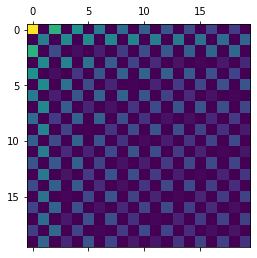

In [35]:
plt.matshow(np.abs(U));

Here's an analogous example with the displacement operator:

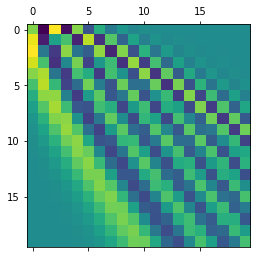

In [36]:
prog = sf.Program(num_subsystems=2)
dim = 20
I = np.identity(dim)

with prog.context as q:
    ops.Ket(I) | q
    ops.Dgate(1.5) | q[0]

eng = sf.LocalEngine(backend='fock', backend_options={'cutoff_dim': dim})
U = eng.run(prog).state.data

plt.matshow(np.real(U));

Obviously, this works also when the unitary that we want to obtain already operates on more than a single Hilbert space, as we will see in the next subsection. Let's use the Strawberry Field function *extract_unitary* which is located in the utils module: behind the scenes it actually implements this trick.

In [37]:
from strawberryfields.utils import extract_unitary

In [38]:
prog = sf.Program(num_subsystems=1)

with prog.context as q:
    ops.Dgate(1.5) | q[0]
    
U_ = utils.extract_unitary(prog, cutoff_dim=dim, backend='fock')

np.allclose(U, U_) 

True

## Multi-mode example: beamsplitter

The Hong-Ou-Mandel effect is an example of destructive interference in quantum optics that occours when two photons interfere in a 1:1 beamsplitter. If they are identical in their physical properties, they will always exit the beam splitter in the same mode.


Here we demonstrate the Hong-Ou-Mandel effect in an unusual way, i.e. by only looking at the unitary operator of the beamsplitter.

We begin by extracting the unitary of a beamsplitter, up to dimension 3 (i.e. for states of up to 2 photons). This is a unitary that acts on two modes, and therefore it has 4 indices: the first pair are output-input indices on the first mode and the second pair are output-input indices on the second mode.

In [39]:
prog = sf.Program(num_subsystems=4)

dim = 3
I = np.identity(dim)
II = np.einsum('ab,cd', I, I) # outer product I_{ab}I_{cd} 

with prog.context as q:
    ops.Ket(II) | q
    ops.BSgate(np.pi/4) | (q[0], q[2]) # the parameter pi/4 leads to the 50/50 beamsplitter

eng = sf.LocalEngine(backend='fock', backend_options={'cutoff_dim': dim})
U = eng.run(prog).state.data

Here we have computed $U_{ia,kc}I_{ab}I_{cd} = U_{ib,kd}$, where $i$ and $k$ are the output indices of the beamsplitter transformation. So let's apply the beamsplitter transformation to a state that has a single photon in each mode (using the _input_ indices $b$ and $d$):

In [40]:
np.abs(U[:,1,:,1])**2

array([[0. , 0. , 0.5],
       [0. , 0. , 0. ],
       [0.5, 0. , 0. ]])

We can see that the only nonzero probabilities correspond to 
the output states $|0,2\rangle$ and $|2,0\rangle$, which means that the photons always exit randomly, but in the same mode (i.e. from the same port of the beamsplitter). This is the essence of the Hong-Ou-Mandel effect.

# Non-unitary Channels
If the channel is not unitary, its description is not going to be in terms of a simple unitary matrix. The reason is the following: while a unitary transformation $U: \mathcal{H}\rightarrow\mathcal{H}$ acts directly on state _vectors_ (i.e. the elements of the Hilbert space $\mathcal{H}$), a non-unitary channel $\mathcal{C}: B(\mathcal{H})\rightarrow B(\mathcal{H})$ is a more general transformation that acts on density _matrices_ (where $\mathcal{B}(\mathcal{H})$ is the space of bounded linear operators on $\mathcal{H}$). 

As a consequence, our modes will now be populated by states expressed by density matrices instead of vectors (and therefore technically each mode really corresponds to 2 copies of a Hilbert space because $B(\mathcal H)\simeq \mathcal{H}\otimes\mathcal{H}$, but this is celverly swept under the rug in Strawberry Fields).

### Kraus, Liouville and Choi representations
We now need to pick a channel representation and then extract it with another Choi-Jamiolkowsky trick. We have several choices of channel representation among Kraus, Liouville and Choi. We will omit the Stinespring representation for now, but we invite the interested reader to have a look at [this work](https://arxiv.org/abs/1111.6950) for illuminating details of all channel representations in a pleasing graphical representation.

Let's see how to obtain the Choi and Liovuille operators from the Kraus matrices.
The way a channel operates on a density matrix $\rho_{ij}^\mathrm{input}$ can be expressed with a set of Kraus operators $A_{ij,k}$, where each Kraus operator is a matrix indexed by $ij$ and where each matrix in the set is indexed through the index $k$ (hence the comma to stress the difference of status between the indices). We compute the action of the cannel by sandwiching the input density matrix between the Kraus operators and then we sum over all sandwiches (which, recall, are indexed by $k$):

$$\rho_{im}^\mathrm{output} = A_{ij,k}\rho_{jl}^\mathrm{input}A_{lm,k}^\dagger$$

where $A_{lm,k}^\dagger = A_{ml,k}^*$ (i.e. $\dagger$ indicates the conjugate-transpose and ${}^*$ indicates just the conjugation).
The Choi operator is essentially the sum of the Kraus sandwiches without the filling and with the appropriate index order:

$$J_{jlim} = A_{ij,k}\ A_{ml,k}^*$$

Incidentally, the Liouville operator is also given by the sandwiches without the filling, but with a different index order:
$L_{mlij} = A_{ij,k}\ A_{ml,k}^*$.

We can use the identity trick again to extract the Choi operator $J$ in Strawberry Fields: $$J_{abij} = A_{ic,k}I_{ac}I_{bd}\ A_{jd,k}^*$$

The desired index order is automatically enforced by Strawberry Fields if we apply the channel on the second mode (indexed by $c$ and $d$), so that the indices of the first mode $a$ and $b$ appear before $i$ and $j$.

### Equivalence of the representations
Using any of the operators to express a quantum channel is exactly equivalent. This is especially clear when expressing the contractions with tensor index notation:

$$\rho_{im}^\mathrm{output} = \rho_{jl}^\mathrm{input}J_{jlim} = \rho_{jl}^\mathrm{input}L_{mlij}=A_{ij,k}\rho_{jl}^\mathrm{input}A_{ml,k}^*$$

Instead, when we want to write the same operations in "regular" notation we may encounter some oddities, for example in the formula of the Choi representation of a channel the input state is transposed:

$$\rho_B^\mathrm{output} = \mathrm{Tr}_A[(\rho^T_A\otimes I_B)J_{AB}]$$

This is a simple consequence of how the indices are arranged, but it may be confusing at first sight. In case of the Liouville representation, we must 'vectorize' and 'unvectorize' the density matrix:

$$\rho^\mathrm{output} = \mathrm{unvec}(L\ \mathrm{vec}(\rho^\mathrm{input}))$$

At this point we hope you can see the advantage of working with tensor indices! 😄

## Single-mode example: lossy bosonic channel
Here we reproduce in code what we presented above, and we will see how to compute the representation of a quantum channel in Strowberry Fields.

In [41]:
dim = 10
prog = sf.Program(num_subsystems=2)
I = np.einsum('ac,bd', np.identity(dim), np.identity(dim)) # notice the order of the indices

with prog.context as q:
    ops.DensityMatrix(I) | q
    ops.LossChannel(0.9) | q[1] # 10% lossy channel on mode B

eng = sf.LocalEngine(backend='fock', backend_options={'cutoff_dim': dim})
J = eng.run(prog).state.data # Choi operator

L = np.einsum('abcd->dbca', J) # Liouville operator

This whole functionality has been implemented since Strawberry Fields v0.10.0 as utility functions, with no need to add modes or to think of tensor indices or contractions:

In [42]:
from strawberryfields.utils import extract_channel

Let's prove that we have succesfully extracted the Choi and the Liouville representation of a channel

In [43]:
prog = sf.Program(num_subsystems=1)
with prog.context as q:
    ops.LossChannel(0.9) | q
    
print(np.allclose(extract_channel(prog, cutoff_dim=dim, representation = 'choi') - J, 0))
print(np.allclose(extract_channel(prog, cutoff_dim=dim, representation = 'liouville') - L, 0))

True
True


## Conclusion

The Choi-Jamiolkowsky isomorphism (aka channel-state duality) is a theoretical result that can find very interesting applications, such as gate teleportation and expressing properties of Bayesian quantum states. However, it's not very common to witness a practical use for it. Here we have seen how Strawberry Fields exploits the CJ isomorphism to obtain a numerical representation of unitary and non-unitary quantum channels.

## Bibliography

[1] ["Channel state duality" PRA 87, 022310 (2013)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.87.022310)

[2] [Program functions in Strawberry Fields](https://strawberryfields.readthedocs.io/en/latest/code/utils.html?strawberryfields.utils.extract_unitary#program-functions)

[3] [Matt Leifer's post on the CJ iso](http://mattleifer.info/2011/08/01/the-choi-jamiolkowski-isomorphism-youre-doing-it-wrong/)